In [10]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from ultralytics import YOLO
import albumentations as A
from albumentations.pytorch import ToTensorV2

import os

import cv2

import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px

from ipywidgets import widgets, VBox, HBox

from IPython.display import display, clear_output

from PIL import Image, ImageDraw, ImageFont

import base64
from io import BytesIO
import shutil
import random

# Finding images containing pothole bounding box and saving to folder

In [8]:
image_dir = 'Combined Data/train_images'
annotation_dir = 'Combined Data/train_annotations'
output_image_dir = 'data/1 Pothole ID model/images'
output_annotation_dir = 'data/1 Pothole ID model/labels'

# Create output directories if they don't exist
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_annotation_dir, exist_ok=True)

# Get lists of image and annotation files
image_files = {os.path.splitext(f)[0] for f in os.listdir(image_dir) if f.endswith('.jpg')}
annotation_files = {os.path.splitext(f)[0] for f in os.listdir(annotation_dir) if f.endswith('.txt')}

# Find the intersection of images and annotations (i.e., pairs that exist in both directories)
matching_files = image_files.intersection(annotation_files)

for file_name in matching_files:
    # Copy the image
    image_path = os.path.join(image_dir, f'{file_name}.jpg')
    output_image_path = os.path.join(output_image_dir, f'{file_name}.jpg')
    shutil.copy(image_path, output_image_path)
    
    # Process the annotation to keep only label 0
    annotation_path = os.path.join(annotation_dir, f'{file_name}.txt')
    output_annotation_path = os.path.join(output_annotation_dir, f'{file_name}.txt')
    
    with open(annotation_path, 'r') as infile, open(output_annotation_path, 'w') as outfile:
        for line in infile:
            if line.startswith('0'):  # Keep only lines that start with label '0'
                outfile.write(line)

print("Filtering completed, and only label 0 annotations were kept.")

Filtering completed, and only label 0 annotations were kept.


# Testing Model

In [39]:
model = YOLO('data/1 Pothole ID model/models/best.pt')


0: 448x640 1 pothole, 189.1ms
Speed: 3.0ms preprocess, 189.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


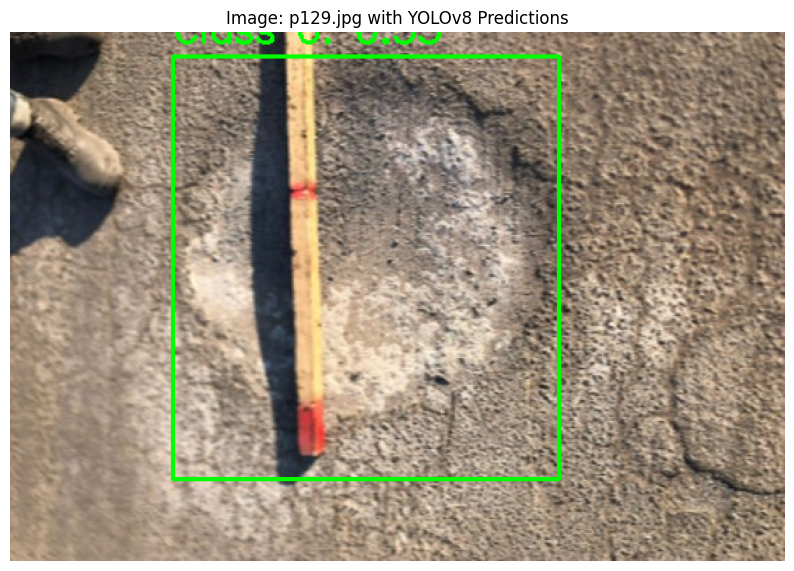

In [45]:
def load_random_image_and_predict_highest(image_dir, model):
    
    # Get the list of images
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    
    if not image_files:
        print("No images found in the directory.")
        return
    
    # Randomly select an image
    selected_image = random.choice(image_files)
    
    # Construct full path to the image
    image_path = os.path.join(image_dir, selected_image)
    
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for plotting
    
    # Use the YOLO model to predict bounding boxes
    results = model(image_rgb)  # Perform inference on the image
    
    # Initialize variables to keep track of the highest confidence box
    highest_conf_box = None
    highest_conf = 0
    
    # Iterate over detected boxes
    for box in results[0].boxes:
        confidence = box.conf[0].item()
        if confidence > highest_conf:
            highest_conf = confidence
            highest_conf_box = box
    
    # Draw the highest confidence bounding box on the image
    if highest_conf_box:
        x_min, y_min, x_max, y_max = map(int, highest_conf_box.xyxy[0].tolist())
        confidence = highest_conf_box.conf[0].item()
        class_id = int(highest_conf_box.cls[0].item())
        
        # Draw the bounding box and label on the image
        label = f'Class {class_id}: {confidence:.2f}'
        cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.putText(image_rgb, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(f'Image: {selected_image} with Highest YOLOv8 Prediction')
    plt.show()

# Example usage:
image_dir = 'Combined Data/train_images'  # Change to your image directory

# Visualize a random image with YOLOv8 predicted bounding boxes
load_random_image_and_predict(image_dir, model)